In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
data_dir="/content/drive/MyDrive/ML_DF.csv"
knn_df= pd.read_csv(data_dir)

In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Assuming green_taxi_df contains your features and target variable
X = knn_df.drop(columns=['trip_price'])  # Adjust 'target_column' to the name of your target column
y = knn_df['trip_price']

# Shuffle the dataset
X_shuffle, y_shuffle = shuffle(X, y, random_state=42)

# Define the sizes for train, cross-validation, and test sets
train_size = 0.6
cv_size = 0.2
test_size = 0.2

X_train, X_temp, y_train, y_temp = train_test_split(X_shuffle, y_shuffle, train_size=train_size, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + cv_size), random_state=42)

# Standardize the data
scalerx = StandardScaler()
X_train_scaled = scalerx.fit_transform(X_train)
X_cv_scaled = scalerx.transform(X_cv)
X_test_scaled = scalerx.transform(X_test)

# Initialize variables to store results
best_k = None
shortest_interval_width = float('inf')
final_accuracy_test = None

# Define the range of k values
k_range = range(1,20,2)  # Adjust the range as needed

# Initialize lists to store k values and corresponding CV error rates
k_values = []
cv_max_errors = []
cv_min_errors = []

for k in k_range:
    cv_errors = []

    # Use 5-fold cross-validation

    # Initialize and train the KNN model
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)

    # Cross-validation
    scores = cross_val_score(model, X_cv_scaled, y_cv, cv=5)  ##scores --> array feeh cross validation error for each subset(fold) per K
    cv_errors.extend(1 - scores) ##1 - scores = error rate for each fold

    # Calculate minimum and maximum CV errors to get the confidence interval
    max_error_cv = max(cv_errors)
    min_error_cv = min(cv_errors)

    # Store k and corresponding CV error
    interval_width = max_error_cv - min_error_cv

    # Update the best k if this interval is the shortest
    if interval_width < shortest_interval_width:
        shortest_interval_width = interval_width
        best_k = k
    k_values.append(k)
    cv_max_errors.append(max_error_cv)
    cv_min_errors.append(min_error_cv)

    print(f"Maximum CV Error for k={k}: {max_error_cv}")
    print(f"Minimum CV Error for k={k}: {min_error_cv}")
    print(f"Width of Confidence Interval for k={k}: {interval_width}")

# Print the best k with the shortest confidence interval
print(f"Best k with Shortest Confidence Interval: {best_k}")

##calculate the final test_error using test data
final_model = KNeighborsClassifier(n_neighbors=best_k)
final_model.fit(X_train_scaled, y_train)
y_test_pred = final_model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy test: {accuracy_test}")

Maximum CV Error for k=1: 0.04407457088888278
Minimum CV Error for k=1: 0.042925974594831384
Width of Confidence Interval for k=1: 0.001148596294051396
Maximum CV Error for k=3: 0.039557611760519085
Minimum CV Error for k=3: 0.03824463425317559
Width of Confidence Interval for k=3: 0.0013129775073434935
Maximum CV Error for k=5: 0.03780661410424879
Minimum CV Error for k=5: 0.03701168934271404
Width of Confidence Interval for k=5: 0.0007949247615347543
Maximum CV Error for k=7: 0.0376423565484012
Minimum CV Error for k=7: 0.0368748117933696
Width of Confidence Interval for k=7: 0.0007675447550316017
Maximum CV Error for k=9: 0.03755919954009146
Minimum CV Error for k=9: 0.036053546497303524
Width of Confidence Interval for k=9: 0.0015056530427879355
Maximum CV Error for k=11: 0.03824463425317559
Minimum CV Error for k=11: 0.036053546497303524
Width of Confidence Interval for k=11: 0.0021910877558720676
Maximum CV Error for k=13: 0.03818988173455984
Minimum CV Error for k=13: 0.03646417

In [ ]:
# From the above results, we can notice that it calculated the maximum and minimum CV error for each k ranging from 1 to 20
# and the final result was for k=7 as it had the minimum width of confidence interval which was equal to 0.0032576856743957716
# the accuracy test was performed on the test set which had accuracy of 97.10310768489521 %
# this was performed using the euclidean distance.

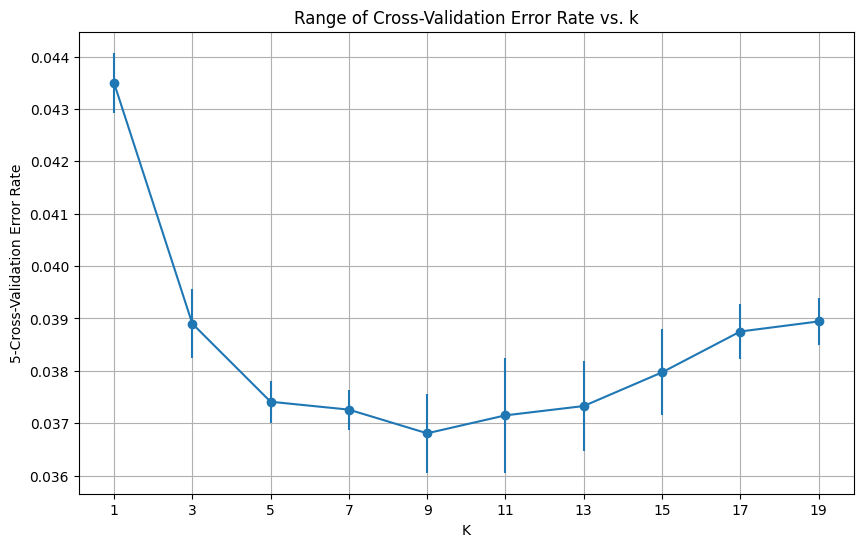

In [8]:
# Plot the CV error rates
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, [(a + b) / 2 for a, b in zip(cv_max_errors, cv_min_errors)], yerr=[abs(b - a) / 2 for a, b in zip(cv_max_errors, cv_min_errors)], fmt='o', linestyle='-')
plt.title('Range of Cross-Validation Error Rate vs. k')
plt.xlabel('K')
plt.ylabel('5-Cross-Validation Error Rate')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [ ]:
# this plot show on the y-axis '5-cross-validation error rate' and on the x-axis 'K'
# from the above graph, we can notice that indeed the shortest width of confidence interval was for k=7.

Confusion Matrix:
[[ 40258    245   2947]
 [   823   6113      0]
 [  1274      2 130982]]
Classification Report:
              precision    recall  f1-score   support

        high       0.95      0.93      0.94     43450
         low       0.96      0.88      0.92      6936
      medium       0.98      0.99      0.98    132258

    accuracy                           0.97    182644
   macro avg       0.96      0.93      0.95    182644
weighted avg       0.97      0.97      0.97    182644



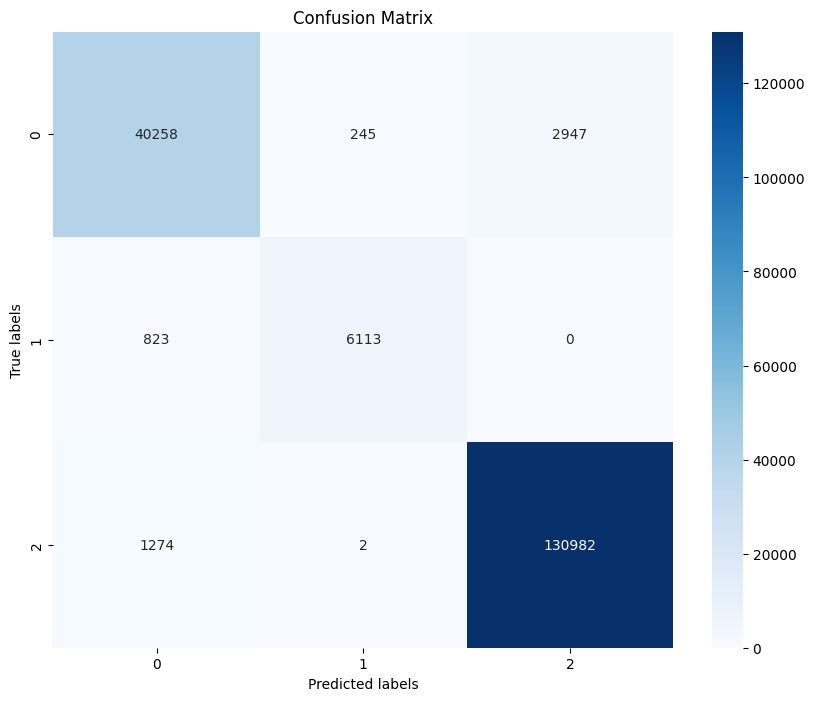

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the classification report
class_report = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(class_report)


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# For the confusion matrix, True Positives (Correct Predictions):
#Class 0: 40258 instances of Class 0 were correctly predicted as Class 0.
#Class 1: 6113 instances of Class 1 were correctly predicted as Class 1.
#Class 2: 130982 instances of Class 2 were correctly predicted as Class 2.

# As for the classification report:
# The "medium" class, which has the most instances, shows the best performance with an F1-score of 0.98.
# Both the macro and weighted averages are high, demonstrating consistent performance across different classes, with the weighted average slightly higher
#   due to the larger number of "medium" instances.

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Sample the data for quicker testing
knn_df_sampled = knn_df.sample(frac=0.1, random_state=42)  # Adjust the fraction as needed for your dataset size

# Assuming knn_df contains your features and target variable
X = knn_df_sampled.drop(columns=['trip_price'])  # Adjust 'trip_price' to the name of your target column
y = knn_df_sampled['trip_price']

# Check for NaN or infinite values
assert not X.isnull().values.any(), "Data contains NaN values"
assert np.isfinite(X.values).all(), "Data contains infinite values"

# Shuffle the dataset
X_shuffle, y_shuffle = shuffle(X, y, random_state=42)

# Define the sizes for train, cross-validation, and test sets
train_size = 0.6
cv_size = 0.2
test_size = 0.2

X_train, X_temp, y_train, y_temp = train_test_split(X_shuffle, y_shuffle, train_size=train_size, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + cv_size), random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

# Calculate the covariance matrix of the training data
epsilon = 1e-10  # Small regularization term
cov_matrix = np.cov(X_train_scaled, rowvar=False) + epsilon * np.eye(X_train_scaled.shape[1])
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Define a custom Mahalanobis distance function using cdist
def mahalanobis_distance(X, Y, VI):
    return cdist(X, Y, metric='mahalanobis', VI=VI)

mahalanobis_distance_func = partial(mahalanobis_distance, VI=inv_cov_matrix)

# Initialize variables to store results
best_k = None
shortest_interval_width = float('inf')
final_accuracy_test = None

# Define the range of k values
k_range = range(1, 20, 2)  # Adjust the range as needed

# Initialize lists to store k values and corresponding CV error rates
k_values = []
cv_max_errors = []
cv_min_errors = []

for k in k_range:
    cv_errors = []

    # Initialize and train the KNN model with Mahalanobis distance
    model = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'VI': inv_cov_matrix})
    model.fit(X_train_scaled, y_train)

    # Cross-validation with parallel processing
    scores = cross_val_score(model, X_cv_scaled, y_cv, cv=5, n_jobs=-1)  # Use all available processors
    cv_errors.extend(1 - scores)  # 1 - scores = error rate for each fold

    # Calculate minimum and maximum CV errors to get the confidence interval
    max_error_cv = max(cv_errors)
    min_error_cv = min(cv_errors)

    # Store k and corresponding CV error
    interval_width = max_error_cv - min_error_cv

    # Update the best k if this interval is the shortest
    if interval_width < shortest_interval_width:
        shortest_interval_width = interval_width
        best_k = k
    k_values.append(k)
    cv_max_errors.append(max_error_cv)
    cv_min_errors.append(min_error_cv)

    print(f"Maximum CV Error for k={k}: {max_error_cv}")
    print(f"Minimum CV Error for k={k}: {min_error_cv}")
    print(f"Width of Confidence Interval for k={k}: {interval_width}")

# Print the best k with the shortest confidence interval
print(f"Best k with Shortest Confidence Interval: {best_k}")

# Calculate the final test_error using test data
final_model = KNeighborsClassifier(n_neighbors=best_k, metric='mahalanobis', metric_params={'VI': inv_cov_matrix})
final_model.fit(X_train_scaled, y_train)
y_test_pred = final_model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy test: {accuracy_test}")


Maximum CV Error for k=1: 0.1021078565562551
Minimum CV Error for k=1: 0.0873254859019984
Width of Confidence Interval for k=1: 0.014782370654256693
Maximum CV Error for k=3: 0.09307418560087599
Minimum CV Error for k=3: 0.07664932931836843
Width of Confidence Interval for k=3: 0.01642485628250756
Maximum CV Error for k=5: 0.08759923350670684
Minimum CV Error for k=5: 0.08075554338899538
Width of Confidence Interval for k=5: 0.006843690117711465
Maximum CV Error for k=7: 0.08871851040525736
Minimum CV Error for k=7: 0.08075554338899538
Width of Confidence Interval for k=7: 0.00796296701626198
Maximum CV Error for k=9: 0.09337349397590367
Minimum CV Error for k=9: 0.08623049548316453
Width of Confidence Interval for k=9: 0.007142998492739139
Maximum CV Error for k=11: 0.09362168081029287
Minimum CV Error for k=11: 0.08842047632083216
Width of Confidence Interval for k=11: 0.005201204489460709
Maximum CV Error for k=13: 0.09745414727621138
Minimum CV Error for k=13: 0.09061045715849991
W

In [ ]:
# From the above results, we can notice that it calculated the maximum and minimum CV error for each k ranging from 1 to 20
# and the final result was for k=11 as it had the minimum width of confidence interval which was equal to 0.005201204489460709
# the accuracy test was performed on the test set which had accuracy of 93.0194360799343 %
# this was performed using the mahalanobis distance because the euclidean distance assumes that the features are uncorrelated.

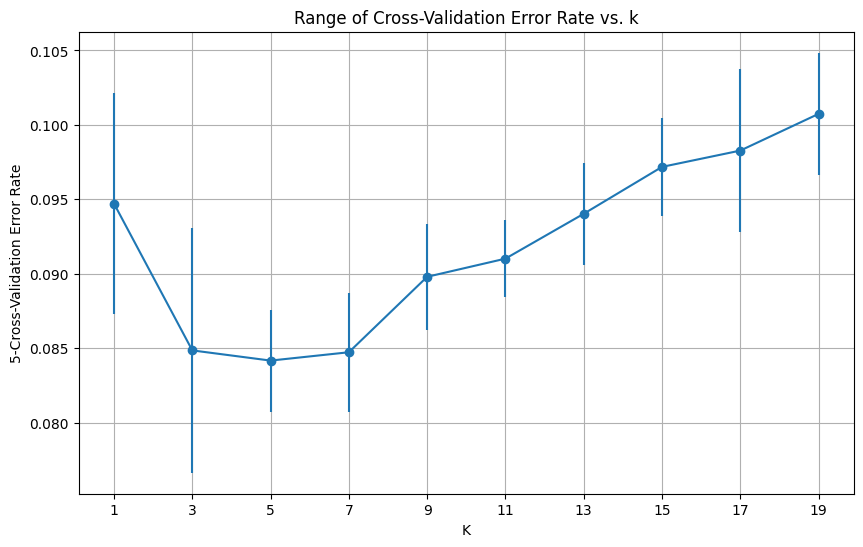

In [ ]:
# Plot the CV error rates
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, [(a + b) / 2 for a, b in zip(cv_max_errors, cv_min_errors)], yerr=[abs(b - a) / 2 for a, b in zip(cv_max_errors, cv_min_errors)], fmt='o', linestyle='-')
plt.title('Range of Cross-Validation Error Rate vs. k')
plt.xlabel('K')
plt.ylabel('5-Cross-Validation Error Rate')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [ ]:
# this plot show on the y-axis '5-cross-validation error rate' and on the x-axis 'K'
# from the above graph, we can notice that indeed the shortest width of confidence interval was for k=11.

Confusion Matrix:
[[ 3456    20   935]
 [  205   469     4]
 [  111     0 13065]]
Classification Report:
              precision    recall  f1-score   support

        high       0.92      0.78      0.84      4411
         low       0.96      0.69      0.80       678
      medium       0.93      0.99      0.96     13176

    accuracy                           0.93     18265
   macro avg       0.94      0.82      0.87     18265
weighted avg       0.93      0.93      0.93     18265



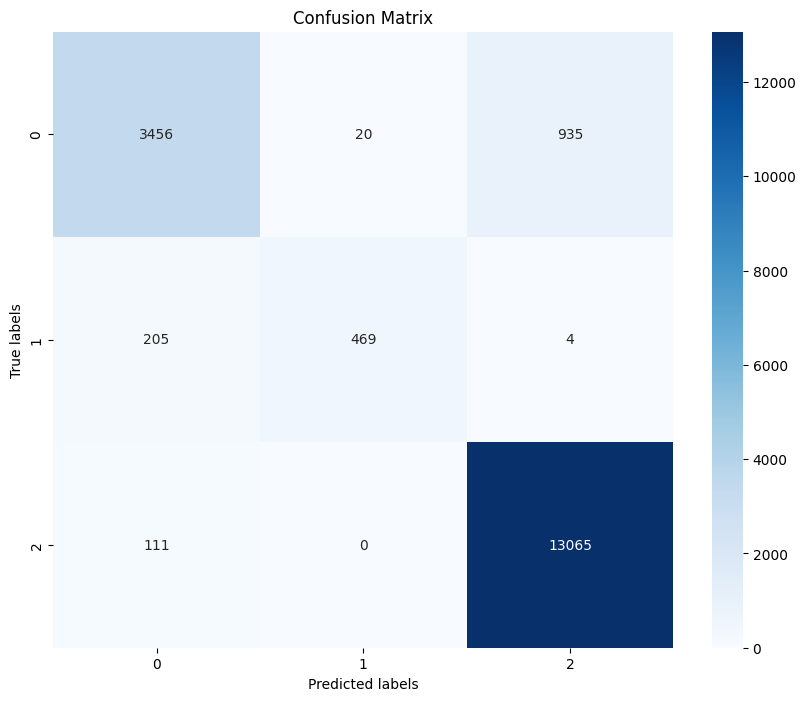

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
conf_matrix_m = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix_m)

# Calculate the classification report
class_report_m = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(class_report_m)


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_m, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# For the confusion matrix, True Positives (Correct Predictions):
#Class 0: 3456 instances of Class 0 were correctly predicted as Class 0.
#Class 1: 469 instances of Class 1 were correctly predicted as Class 1.
#Class 2: 13065 instances of Class 2 were correctly predicted as Class 2.

# As for the classification report:
# It indicated that the classifier performs well overall, with high precision, recall, and F1-scores for all classes, particularly for the "medium" class.
# The accuracy of 93% shows that the classifier is effective at correctly predicting the class labels for the majority of instances.
# The macro and weighted averages provide a balanced view of the classifier's performance, with the weighted averages indicating the classifier's
# strong performance across the dataset, considering the class distribution.